In [1]:
# Just disables the warning, doesn't take advantage of AVX/FMA to run faster
# see https://stackoverflow.com/questions/47068709/your-cpu-supports-instructions-that-this-tensorflow-binary-was-not-compiled-to-u
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from tensorflow import keras
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

2022-10-22 18:17:06.975116: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Load MNIST dataset

In [3]:
(X_train, _), (X_test, _) = keras.datasets.mnist.load_data()

In [4]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
image_size = X_train.shape[1] # 28

In [6]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [7]:
X_train.shape

(60000, 28, 28, 1)

In [8]:
X_train.dtype

dtype('uint8')

Have to make it float 32 to work with TF

In [9]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


In [10]:
X_train.max()

255.0

Have to put everything in range 0, 1

In [11]:
X_train = X_train/255.
X_test = X_test/255.


In [12]:
X_train.max()

1.0

In [13]:
batch_size = 32

In [14]:
kernel_size = 3 

In [15]:
latent_dim = 16

In [16]:
layer_filters = [32, 64] # for conv 2d

In [17]:
inputs = keras.layers.Input(shape=(image_size, image_size, 1), name='encoder_input')
inputs

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'encoder_input')>

In [18]:
x = inputs

Encoder layers:

In [19]:
x = keras.layers.Conv2D(32, kernel_size, activation='relu', strides=2, padding='same')(x)

2022-10-22 18:17:10.288786: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


After this layer, the shape would be 13, 13, 1 ((28-3 + 2*1)//2 +1)

In [20]:
((28-3 + 2*1)//2 +1)

14

In [21]:
x = keras.layers.Conv2D(64, kernel_size, activation='relu', strides=2, padding='same')(x)

After this layer, the shape would be 7, 7, 1 ((14-3 + 2*1)/2 +1 )

In [22]:
((13-3 + 2*1)/2 +1 )

7.0

Input from the last encoder layer would be of shape -1, 7, 7, 64 and the expected output from the decoder is of the shape -1, 28, 28, 1

In [23]:
K.int_shape(x)

(None, 7, 7, 64)

In [24]:
shape = K.int_shape(x)

Make layent vector

In [25]:
x = keras.layers.Flatten()(x)

In [26]:
latent = keras.layers.Dense(latent_dim, name='latent_vector')(x)

In [27]:
K.int_shape(x)

(None, 3136)

In [28]:
encoder = keras.Model(inputs, latent, name='encoder')

In [29]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


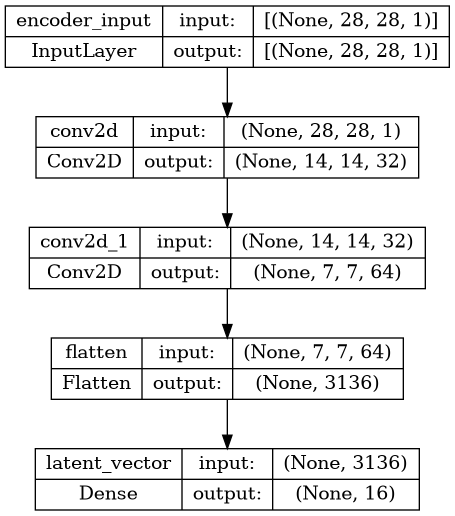

In [30]:
keras.utils.plot_model(encoder, show_shapes=True)

Build the decoder model

In [31]:
latent_inputs = keras.Input(shape=(latent_dim, ), name='decoder_input')

In [32]:
x_d = keras.layers.Dense(shape[1]*shape[2]*shape[3])(latent_inputs) # so that I can reshape it to the expected output shape

In [33]:
K.int_shape(x_d)

(None, 3136)

In [34]:
x_d = keras.layers.Reshape(shape[1:])(x_d)

In [35]:
K.int_shape(x_d)

(None, 7, 7, 64)

Now have upsampling layers, but filters in reverse ordr

In [36]:
x_d = keras.layers.Conv2DTranspose(64, kernel_size, activation='relu', strides=2, padding='same')(x_d)

In [37]:
x_d = keras.layers.Conv2DTranspose(32, kernel_size, activation='relu', strides=2, padding='same')(x_d)

In [38]:
K.int_shape(x_d)

(None, 28, 28, 32)

In [39]:
outputs = keras.layers.Conv2DTranspose(1, kernel_size, activation='sigmoid', strides=1, padding='same', name='decoder_output')(x_d)

In [40]:
K.int_shape(outputs)

(None, 28, 28, 1)

In [41]:
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289 

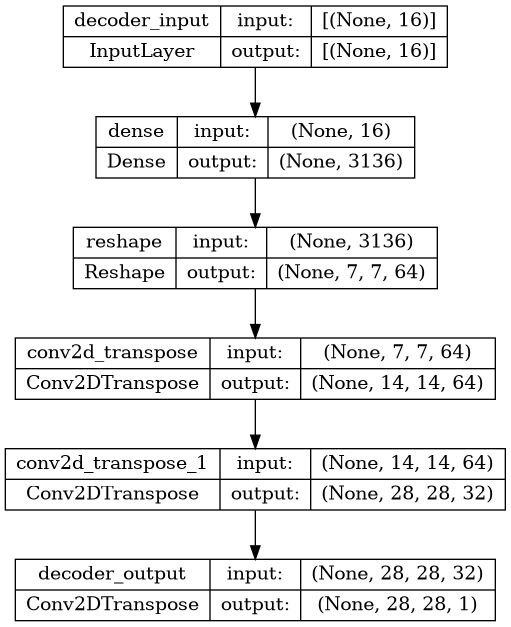

In [42]:
keras.utils.plot_model(decoder, show_shapes=True)

In [43]:
autoencoder = keras.Model(inputs, decoder(encoder(inputs)), name='autoencoder')

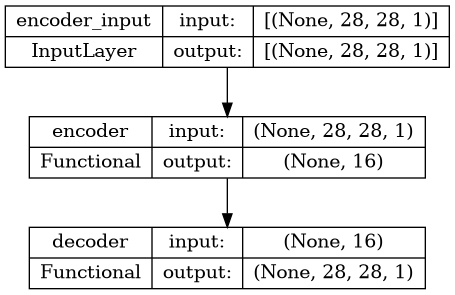

In [44]:
keras.utils.plot_model(autoencoder, show_shapes=True)

Compile model

In [45]:
keras.losses.MSE

<function keras.losses.mean_squared_error(y_true, y_pred)>

In [46]:
opt = keras.optimizers.Adam() # have to instantialize before passing to compile

In [47]:
autoencoder.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=opt)

In [48]:
autoencoder.fit(X_train, X_train, validation_data=(X_test, X_test), epochs=1, batch_size=batch_size)  # input is the target

1875/1875 [==============================] - 32s 17ms/step - loss: 0.1243 - val_loss: 0.0926


In [49]:
x_decoded = autoencoder.predict(X_test)

313/313 [==============================] - 2s 6ms/step


Display the predicted images

In [50]:
x_decoded.shape

(10000, 28, 28, 1)

In [51]:
image_size

28

In [52]:
x_decoded[:4, :].shape

(4, 28, 28, 1)

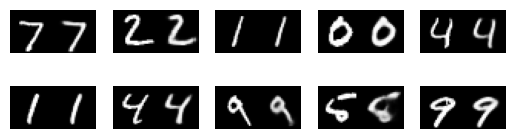

In [53]:
for idx in range(10):
    plt.subplot(5, 5, idx+1)
    tmp = np.hstack([X_test[idx, :], x_decoded[idx, :]])
    plt.imshow(tmp, cmap='gray')
    plt.axis('off')
    